In [214]:
import pandas as pd

# Load the dataset
df = pd.read_csv('final_dataset_encoded.csv', low_memory=False)

# Split data by academic year
df_2021 = df[df['academicYear'] == 2021]
df_2022 = df[df['academicYear'] == 2022]

# Find common ids between the two years
common_ids = set(df_2021['idOSYM']).intersection(set(df_2022['idOSYM']))

# Convert to a list or back to a Series if needed
common_ids = list(common_ids)  # Or pd.Series(common_ids)

print(len(df_2022))
print(len(common_ids))


9250
8632


## Lag Features

In [215]:
df['lag_baseRanking'] = df.groupby(['universityName_encoded', 'departmentName_encoded', 'scholarshipRate'])['baseRanking'].shift(1)
df['lag_baseRanking'] = df['lag_baseRanking'].fillna(df['baseRanking'])
df['lag_quota'] = df.groupby(['universityName_encoded', 'departmentName_encoded', 'scholarshipRate'])['quota'].shift(1)
df['lag_quota'] = df['lag_quota'].fillna(df['quota'])
df['lag_revenue'] = df.groupby(['universityName_encoded', 'departmentName_encoded', 'scholarshipRate'])['revenue'].shift(1)
df['lag_revenue'] = df['lag_revenue'].fillna(df['revenue'])

print(df.head())


   academicYear     idOSYM  scholarshipRate  quota  occupiedSlots  tuitionFee  \
0          2021  106510077              0.0     70             70         0.0   
1          2022  106510077              0.0     75             75         0.0   
2          2023  106510077              0.0     75             75         0.0   
3          2021  106510087              0.0     60             62         0.0   
4          2022  106510087              0.0     65             67         0.0   

   universityLocation  universityRegion  profCount  assoCount  ...  \
0                  41                 6        1.0        1.0  ...   
1                  41                 6        1.0        1.0  ...   
2                  41                 6        0.0        1.0  ...   
3                  41                 6        1.0        0.0  ...   
4                  41                 6        1.0        1.0  ...   

   language_Çince  language_İngilizce  language_İspanyolca  \
0               0             

## Year-over-Year Change Features

In [216]:
df['yoy_baseRanking'] = df['baseRanking'] - df['lag_baseRanking']
df['yoy_quota'] = df['quota'] - df['lag_quota']
df['yoy_revenue'] = df['revenue'] - df['lag_revenue']

print(df.head())


   academicYear     idOSYM  scholarshipRate  quota  occupiedSlots  tuitionFee  \
0          2021  106510077              0.0     70             70         0.0   
1          2022  106510077              0.0     75             75         0.0   
2          2023  106510077              0.0     75             75         0.0   
3          2021  106510087              0.0     60             62         0.0   
4          2022  106510087              0.0     65             67         0.0   

   universityLocation  universityRegion  profCount  assoCount  ...  \
0                  41                 6        1.0        1.0  ...   
1                  41                 6        1.0        1.0  ...   
2                  41                 6        0.0        1.0  ...   
3                  41                 6        1.0        0.0  ...   
4                  41                 6        1.0        1.0  ...   

   language_İtalyanca  universityName_encoded  departmentName_encoded  \
0                  

In [218]:
print(df.isnull().sum())

academicYear       0
idOSYM             0
scholarshipRate    0
quota              0
occupiedSlots      0
                  ..
lag_quota          0
lag_revenue        0
yoy_baseRanking    0
yoy_quota          0
yoy_revenue        0
Length: 73, dtype: int64


## Economic Features and Trends

In [219]:
# Lagging economic features
df['lag_inflation'] = df.groupby('academicYear')['inflation_by_year'].shift(1)
df['lag_growth_rate'] = df.groupby('academicYear')['growth_by_year'].shift(1)
df['lag_base_salary'] = df.groupby('academicYear')['base_salary_by_year'].shift(1)

df['lag_inflation'] = df['lag_inflation'].fillna(df['inflation_by_year'])
df['lag_growth_rate'] = df['lag_growth_rate'].fillna(df['growth_by_year'])
df['lag_base_salary'] = df['lag_base_salary'].fillna(df['base_salary_by_year'])

# Inflation-adjusted features
df['real_tuition_fee'] = df['tuitionFee'] / (1 + df['inflation_by_year'] / 100)
df['real_base_salary'] = df['base_salary_by_year'] / (1 + df['inflation_by_year'] / 100)

# Ratios and trends
df['tuition_to_salary_ratio'] = df['tuitionFee'] / df['base_salary_by_year']
df['growth_to_inflation_ratio'] = df['growth_by_year'] / df['inflation_by_year']
df['inflation_trend'] = df['inflation_by_year'] - df['lag_inflation']

# print(df.head())
print(df.isnull().sum())

academicYear                 0
idOSYM                       0
scholarshipRate              0
quota                        0
occupiedSlots                0
                            ..
real_tuition_fee             0
real_base_salary             0
tuition_to_salary_ratio      0
growth_to_inflation_ratio    0
inflation_trend              0
Length: 81, dtype: int64


In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

binary_features = [
    'universityType_devlet', 'universityType_vakıf', 'programType_DİL', 'programType_EA', 
    'programType_SAY', 'programType_SÖZ', 'language_Almanca', 'language_Arapça', 'language_Bulgarca', 'language_English', 
    'language_Ermenice', 'language_Fransızca', 'language_Korece', 'language_Lehçe', 'language_Rusça', 'language_Turkish', 
    'language_Türkçe', 'language_Çince', 'language_İngilizce', 'language_İspanyolca', 'language_İtalyanca', 
    'academicYear', 'baseRanking' ,'idOSYM'
]
print(df[binary_features].describe().round(3))
print(len(binary_features))


       universityType_devlet  universityType_vakıf  programType_DİL  \
count              27687.000             27687.000        27687.000   
mean                   0.598                 0.402            0.051   
std                    0.490                 0.490            0.220   
min                    0.000                 0.000            0.000   
25%                    0.000                 0.000            0.000   
50%                    1.000                 0.000            0.000   
75%                    1.000                 1.000            0.000   
max                    1.000                 1.000            1.000   

       programType_EA  programType_SAY  programType_SÖZ  language_Almanca  \
count       27687.000        27687.000        27687.000         27687.000   
mean            0.320            0.456            0.173             0.004   
std             0.467            0.498            0.378             0.066   
min             0.000            0.000            0.

In [221]:

encoded_features = ['universityName_encoded', 'departmentName_encoded', 'facultyName_encoded']
print(df[encoded_features].describe().round(3))

numeric_features = []
for feature in df.columns:
    if feature not in binary_features:
        numeric_features.append(feature)
        
print(len(numeric_features))

       universityName_encoded  departmentName_encoded  facultyName_encoded
count               27687.000               27687.000            27687.000
mean                  266.489                 266.489              266.489
std                    83.229                 153.768              124.241
min                    40.175                   0.000                0.000
25%                   202.341                 142.345              159.310
50%                   274.235                 270.523              295.544
75%                   333.143                 396.597              325.321
max                   525.039                 969.993              767.799
57


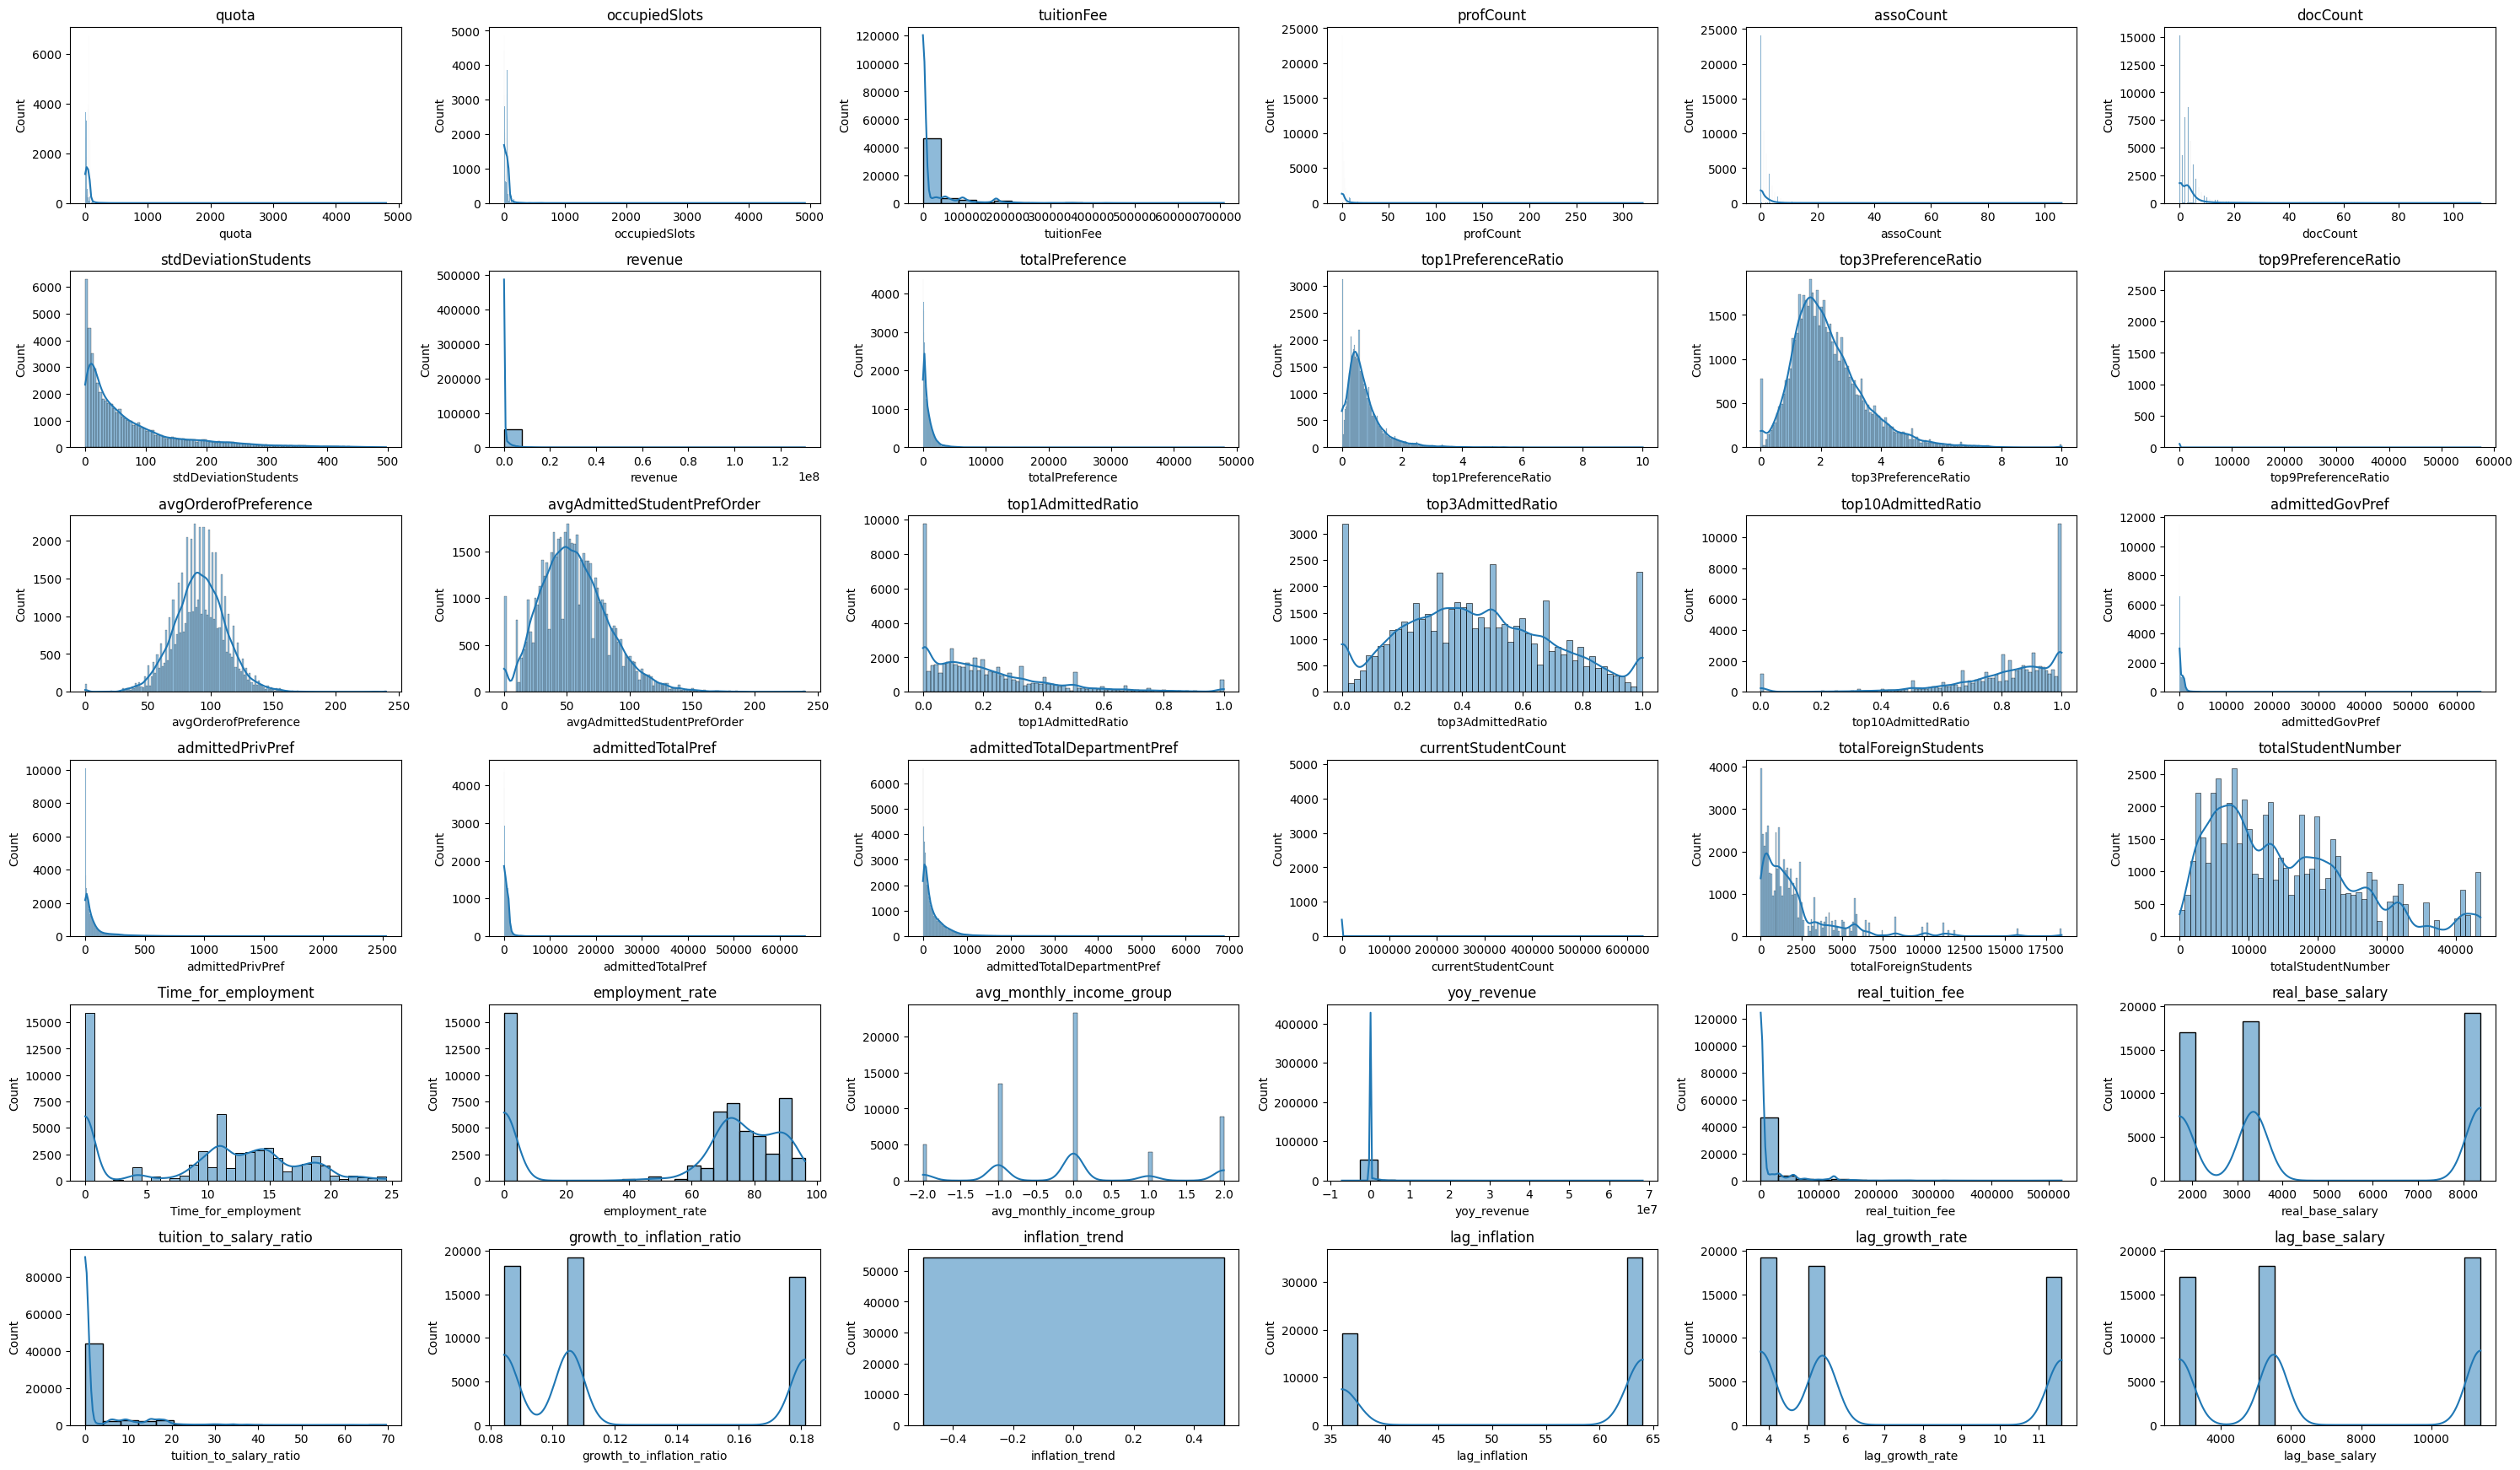

In [ ]:
# Plot histograms for continuous features
plt.figure(figsize=(30, 20))
for i, feature in enumerate(numeric_features):
    plt.subplot(7, 6, i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()



In [222]:
# Calculate skewness of each continuous feature
skew_values = df[numeric_features].skew()

# Filter features with skewness greater than 1 or less than -1 (this is an arbitrary threshold)
skew_features = skew_values[abs(skew_values) > 1].index.tolist()

# Display skew features
print("Skewed Features:", skew_features)
print(len(skew_features))

continuous_features = [col for col in numeric_features if col not in skew_features]

print("Continous Features:", continuous_features)
print(len(continuous_features))

Skewed Features: ['quota', 'occupiedSlots', 'tuitionFee', 'universityRegion', 'profCount', 'assoCount', 'docCount', 'topRanking', 'stdDeviationStudents', 'revenue', 'totalPreference', 'top1PreferenceRatio', 'top3PreferenceRatio', 'top9PreferenceRatio', 'top1AdmittedRatio', 'top10AdmittedRatio', 'admittedGovPref', 'admittedPrivPref', 'admittedTotalPref', 'admittedTotalDepartmentPref', 'currentStudentCount', 'totalForeignStudents', 'lag_quota', 'lag_revenue', 'yoy_baseRanking', 'yoy_quota', 'yoy_revenue', 'real_tuition_fee', 'tuition_to_salary_ratio']
29
Continous Features: ['scholarshipRate', 'universityLocation', 'outOfCityStudentRate', 'sameRegionStudentRate', 'avgOrderofPreference', 'avgAdmittedStudentPrefOrder', 'top3AdmittedRatio', 'totalStudentNumber', 'Urap_Rank', 'Urap_Score', 'avg_monthly_income_group', 'Time_for_employment', 'employment_rate', 'base_salary_by_year', 'inflation_by_year', 'growth_by_year', 'avgAdmissionRanking', 'baseAdmissionRanking', 'universityName_encoded', 

In [223]:
print(df.isnull().sum())

academicYear                 0
idOSYM                       0
scholarshipRate              0
quota                        0
occupiedSlots                0
                            ..
real_tuition_fee             0
real_base_salary             0
tuition_to_salary_ratio      0
growth_to_inflation_ratio    0
inflation_trend              0
Length: 81, dtype: int64


In [224]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# Define transformations
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()
encoder = OneHotEncoder(handle_unknown='ignore')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical features (standard scaling)
        ('num', scaler_standard, continuous_features),
        
        # Skewed features (log transformation + standard scaling)
        ('skewed', Pipeline(steps=[
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', scaler_standard)
        ]), skew_features),
    ]
)

# Add a small constant to skewed features to avoid -inf values
df[skew_features] = df[skew_features] + 0.1

processed_data = preprocessor.fit_transform(df)

processed_df = pd.DataFrame(processed_data, columns=continuous_features + skew_features)

print(processed_df[numeric_features].describe().round(3))



       scholarshipRate      quota  occupiedSlots  tuitionFee  \
count        27687.000  27687.000      27687.000   27687.000   
mean             0.000     -0.000         -0.000       0.000   
std              1.000      1.000          1.000       1.000   
min             -0.684     -2.688         -2.707      -0.508   
25%             -0.684     -0.702         -0.793      -0.508   
50%             -0.684      0.305          0.232      -0.508   
75%              0.564      0.705          0.789      -0.508   
max              1.812      5.097          4.550       2.473   

       universityLocation  universityRegion  profCount  assoCount   docCount  \
count           27687.000         27687.000  27687.000  27687.000  27687.000   
mean               -0.000             0.000     -0.000     -0.000      0.000   
std                 1.000             1.000      1.000      1.000      1.000   
min                -1.726            -2.743     -0.843     -0.879     -1.261   
25%                -0.9

/Users/omeryildiz/Documents/GitHub/WebScraping-Dataset-/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_function_transformer.py:379: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


In [225]:
print(df.isnull().sum())

academicYear                 0
idOSYM                       0
scholarshipRate              0
quota                        0
occupiedSlots                0
                            ..
real_tuition_fee             0
real_base_salary             0
tuition_to_salary_ratio      0
growth_to_inflation_ratio    0
inflation_trend              0
Length: 81, dtype: int64


## Feature Selection 

In [226]:

# Split data by academic year
df_2021 = df[df['academicYear'] == 2021]
df_2022 = df[df['academicYear'] == 2022]

# Filter rows based on common IDs
common_ids = set(df_2021['idOSYM']).intersection(set(df_2022['idOSYM']))

df_2021_filtered = df_2021[df_2021['idOSYM'].isin(common_ids)].sort_values(by='idOSYM')
df_2022_filtered = df_2022[df_2022['idOSYM'].isin(common_ids)].sort_values(by='idOSYM')

# Prepare X and y
X = df_2021_filtered.drop(columns=['baseRanking', 'academicYear', 'idOSYM'])
y = df_2022_filtered['baseRanking']

# Check for missing values
print("Missing values in X:", X.isnull().sum().sum())
print("Missing values in y:", y.isnull().sum())

# Display shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Missing values in X: 0
Missing values in y: 0
Shape of X: (8632, 78)
Shape of y: (8632,)


In [227]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model_feature = RandomForestRegressor(random_state=42)
model_feature.fit(X_train, y_train)

# Get feature importance
feature_importances = model_feature.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

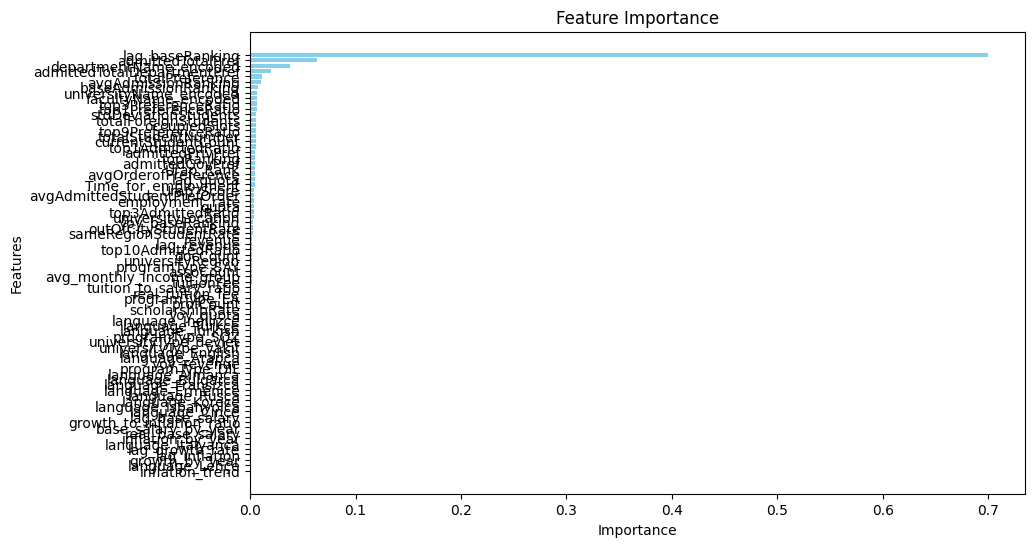

                        Feature  Importance
64              lag_baseRanking    0.700030
25            admittedTotalPref    0.063587
62       departmentName_encoded    0.037913
26  admittedTotalDepartmentPref    0.019327
14              totalPreference    0.011423
38          avgAdmissionRanking    0.010706
39         baseAdmissionRanking    0.007902
61       universityName_encoded    0.006778
63          facultyName_encoded    0.006475
16          top3PreferenceRatio    0.006387


In [228]:

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

# Print top 30 most important features
print(importance_df.head(10))

In [229]:
print(X_train.isnull().sum())

scholarshipRate              0
quota                        0
occupiedSlots                0
tuitionFee                   0
universityLocation           0
                            ..
real_tuition_fee             0
real_base_salary             0
tuition_to_salary_ratio      0
growth_to_inflation_ratio    0
inflation_trend              0
Length: 78, dtype: int64


## Baseline Model

In [234]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

base_model = LinearRegression()
base_model.fit(X_train, y_train)

y_pred_base = base_model.predict(X_test)

rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)
mae_base = mean_absolute_error(y_test, y_pred_base)
r2_base = r2_score(y_test, y_pred_base)

print(f"Baseline Model Metrics:\nRMSE: {rmse_base:.4f}, MAE: {mae_base:.4f}, R^2: {r2_base:.4f}")


Baseline Model Metrics:
RMSE: 369.6066, MAE: 82.0586, R^2: -1.3830


/Users/omeryildiz/Documents/GitHub/WebScraping-Dataset-/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
complex_model = RandomForestRegressor(random_state=42, n_estimators=100)
complex_model.fit(X_train, y_train)

# Predict on test data
y_pred_complex = complex_model.predict(X_test)
# Calculate metrics
rmse_complex = mean_squared_error(y_test, y_pred_complex)
mae_complex = mean_absolute_error(y_test, y_pred_complex)
r2_complex = r2_score(y_test, y_pred_complex)

print(f"Complex Model Metrics:\nRMSE: {rmse_complex:.4f}, MAE: {mae_complex:.4f}, R^2: {r2_complex:.4f}")


[119.20183 479.35174  16.72634 ...   4.37821 194.14415  18.03575]
Complex Model Metrics:
RMSE: 9668.7028, MAE: 47.9251, R^2: 0.8313


## Fine-Tune Model

In [235]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Fine-Tuned Model Metrics:\nRMSE: {rmse_best:.4f}, MAE: {mae_best:.4f}, R^2: {r2_best:.4f}")


Best parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Fine-Tuned Model Metrics:
RMSE: 97.8627, MAE: 47.3621, R^2: 0.8329


/Users/omeryildiz/Documents/GitHub/WebScraping-Dataset-/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Visualize

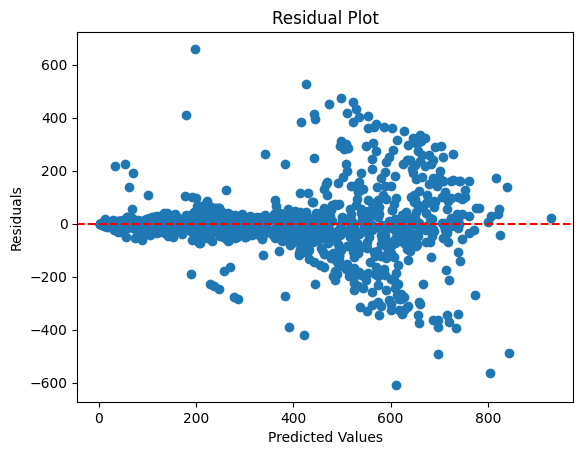

In [236]:
# Residual plot
import matplotlib.pyplot as plt

residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [241]:

# Split data for 2022 and 2023
df_2022 = df[df['academicYear'] == 2022]
df_2023 = df[df['academicYear'] == 2023]

# Filter rows based on common IDs between 2022 and 2023
common_ids_2022_2023 = set(df_2022['idOSYM']).intersection(set(df_2023['idOSYM']))

df_2022_filtered = df_2022[df_2022['idOSYM'].isin(common_ids_2022_2023)].sort_values(by='idOSYM')
df_2023_filtered = df_2023[df_2023['idOSYM'].isin(common_ids_2022_2023)].sort_values(by='idOSYM')

print("Shape of 2022 data:", df_2022_filtered.shape)
print("Shape of 2023 data:", df_2023_filtered.shape)

# Prepare X_2022 and y_2023
X_2022 = df_2022_filtered.drop(columns=['baseRanking', 'academicYear', 'idOSYM'])
y_2023 = df_2023_filtered['baseRanking']

Shape of 2022 data: (8991, 81)
Shape of 2023 data: (8991, 81)


In [ ]:
# Train the second model
model_2 = RandomForestRegressor(random_state=42, n_estimators=100)
model_2.fit(X_2022, y_2023)

# Predict 2023 rankings
y_pred_2023 = model_2.predict(X_2022)

rmse = mean_squared_error(y_2023, y_pred_2023, squared=False)
mae = mean_absolute_error(y_2023, y_pred_2023)
r2 = r2_score(y_2023, y_pred_2023)

print(f"Second Model Metrics:\nRMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")


Second Model Metrics:
RMSE: 40.3830, MAE: 19.0396, R^2: 0.9728


/Users/omeryildiz/Documents/GitHub/WebScraping-Dataset-/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
